<a href="https://colab.research.google.com/github/tohpedo/wikibot/blob/seq2seq/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
# base

base = pd.read_csv("/content/drive/MyDrive/Squad/database.csv")[:6000]

In [4]:
# define function to clean the text 

def clean_text(text):

    text = text.lower()
    text = re.sub(r"\n", "",  text)
    text = re.sub(r"[-()]", "", text)
    text = re.sub(r"\.", " . ", text)
    text = re.sub(r"\!", " ! ", text)
    text = re.sub(r"\?", " ? ", text)
    text = re.sub(r"\,", " , ", text)
    text = re.sub(r"\"", " \" ", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)

    
    return text

# **Base Processing**

In [5]:
# base processing 

base = base.dropna()

# defining lenghts of q's and a's

q_text = []

for line in base.question:
    q_text.append(clean_text(line))

q_len = []
for line in q_text:
    q_len.append(len(line.split()))

max_q_length = max(q_len)

a_text = []
for line in base.text:
    a_text.append(clean_text(line))

a_len = []
for line in a_text:
    a_len.append(len(line.split()))

# plus two due to tokens
max_a_length = max(a_len) + 2

# adding tokens to answers
for i in range(len(a_text)):
    a_text[i]  = "<BOS> " + a_text[i] + " <EOS>"


In [6]:
# vocab and tokenizing
# making vocab
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 10000
tokenizer = Tokenizer(num_words = vocab_size, lower=False, filters="")
tokenizer.fit_on_texts(q_text + a_text)
dictionary = tokenizer.word_index

word2token = {}
token2word = {}

for k, v in dictionary.items():
    if v < vocab_size:
        word2token[k] = v
        token2word[v] = k
    else:
        continue

vocab_size = len(word2token) + 1

# tokenizing sentences

encoder_seq = tokenizer.texts_to_sequences(q_text)
decoder_seq = tokenizer.texts_to_sequences(a_text)

In [7]:
# padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

encoder_input = pad_sequences(encoder_seq, 
                              maxlen = max_q_length,
                              padding = "post",
                              truncating= "post")

decoder_input = pad_sequences(decoder_seq, 
                              maxlen = max_a_length,
                              padding = "post",
                              truncating= "post")


In [8]:
# formating decoder output
for i in range(len(decoder_seq)):
    decoder_seq[i] =  decoder_seq[i][1:]
    
# pad with 0
padded_answers = pad_sequences(decoder_seq,
                               maxlen = max_a_length,
                               padding = "post")


In [9]:
#deleting non-necessary variables
del(a_len, a_text, decoder_seq, dictionary, encoder_seq, i, k, line, q_len, q_text,  v)

In [10]:
decoder_output = to_categorical(padded_answers, vocab_size)

In [11]:
#deleting non-necessary variables
del(padded_answers)

# **Model**

In [12]:
#defining functions to custom metrics

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [13]:
# train test splitting

from sklearn.model_selection import train_test_split

encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_output_train, decoder_output_test = train_test_split(encoder_input,
                                                                                                                                               decoder_input,
                                                                                                                                               decoder_output)

del(encoder_input,decoder_input, decoder_output)

In [14]:
# =============================================================================
# Model
# =============================================================================
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input
from tensorflow.keras import optimizers

# encoder will be used to capture space-dependent relations between words from the questions
# about 200 neurons needed 

emedding_size = 512
enc_inputs = Input(shape=(None,))
enc_embeding = Embedding(vocab_size, emedding_size, mask_zero=True)
enc_embeding = enc_embeding(enc_inputs)
enc_lstm = LSTM(emedding_size,  return_state=True)
enc_outputs, h, c = enc_lstm(enc_embeding)
enc_states = [h, c]

# decoder will be used to capture space-dependent relations between words from the answers using encoder's internal state as a context

dec_inputs = Input(shape=(None,))
dec_embedding = Embedding(vocab_size, emedding_size, mask_zero=True)
dec_embedding = dec_embedding(dec_inputs)
dec_lstm = LSTM(emedding_size, return_state=True, return_sequences=True)
dec_outputs, _, _ = dec_lstm(dec_embedding, initial_state = enc_states)

# decoder is connected to the output Dense layer
dec_dense = Dense(vocab_size, activation = "softmax")
output = dec_dense(dec_outputs)

model = Model([enc_inputs, dec_inputs], output)
lr = 0.001
# output of this network will look like this:
# y_true = [0.05, 0.95, 0...]
# and expected one-hot encoded output like this:
# y_pred = [0, 1, 0...]
model.compile(optimizer = optimizers.Adam(learning_rate = lr), loss = "categorical_crossentropy", metrics = ["acc", f1_m, precision_m, recall_m])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 512)    4481024     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 512)    4481024     ['input_2[0][0]']                
                                                                                              

# **Training**

In [15]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [16]:
# creating checkpoints
import os
import tensorflow as tf

checkpoint_path = "/content/drive/MyDrive/Squad/training_6/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

# **The Actual Bot part**

use only while training

In [17]:
# fitting the model
history = model.fit([encoder_input_train, decoder_input_train],
          decoder_output_train,
          validation_split = 0.2,
          batch_size = 32,
          epochs = 40,
          callbacks = [cp_callback])

Epoch 1/40
106/106 [==============================] - ETA: 0s - loss: 0.5643 - acc: 0.4027 - f1_m: 0.0302 - precision_m: 0.6709 - recall_m: 0.0155
Epoch 00001: saving model to /content/drive/MyDrive/Squad/training_6/cp.ckpt
106/106 [==============================] - 24s 118ms/step - loss: 0.5643 - acc: 0.4027 - f1_m: 0.0302 - precision_m: 0.6709 - recall_m: 0.0155 - val_loss: 0.4809 - val_acc: 0.4587 - val_f1_m: 0.0685 - val_precision_m: 0.8403 - val_recall_m: 0.0357
Epoch 2/40
106/106 [==============================] - ETA: 0s - loss: 0.4382 - acc: 0.4594 - f1_m: 0.0713 - precision_m: 0.8858 - recall_m: 0.0372
Epoch 00002: saving model to /content/drive/MyDrive/Squad/training_6/cp.ckpt
106/106 [==============================] - 10s 92ms/step - loss: 0.4382 - acc: 0.4594 - f1_m: 0.0713 - precision_m: 0.8858 - recall_m: 0.0372 - val_loss: 0.4818 - val_acc: 0.4601 - val_f1_m: 0.0730 - val_precision_m: 0.8539 - val_recall_m: 0.0381
Epoch 3/40
106/106 [==============================] - ETA

In [18]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_acc', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


Accuracy plot

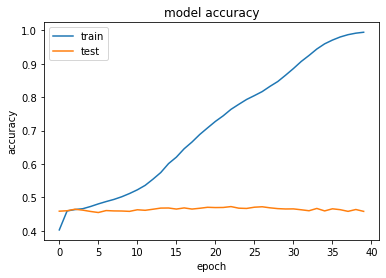

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Loss plot

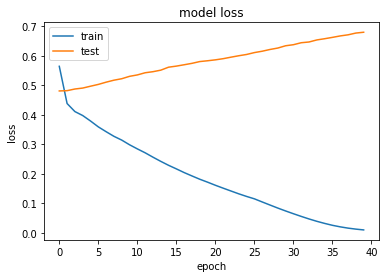

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Scores

In [21]:
loss, accuracy, f1_score, precision, recall = model.evaluate([encoder_input_test, decoder_input_test],
                                                             decoder_output_test, 
                                                             verbose = 1)


45/45 [==============================] - 2s 53ms/step - loss: 0.6904 - acc: 0.4517 - f1_m: 0.0807 - precision_m: 0.7187 - recall_m: 0.0428


In [22]:
print("F1 Score = {}".format(f1_score))
print("Precision = {}".format(precision))
print("Recall = {}".format(recall))

F1 Score = 0.08067158609628677
Precision = 0.7187038064002991
Recall = 0.042756062000989914


use once trained

In [23]:
# Loads the weights
model.load_weights(checkpoint_path)


**BOT**

In [24]:
# =============================================================================
# Bot
# =============================================================================

def make_inference_models():
    # two inputs for the state vectors returned by encoder
    dec_state_input_h = Input(shape=(emedding_size,))
    dec_state_input_c = Input(shape=(emedding_size,))
    dec_states_inputs = [dec_state_input_h, dec_state_input_c]
    # these state vectors are used as an initial state 
    # for LSTM layer in the inference decoder
    # third input is the Embedding layer as explained above   
    dec_outputs, h, c = dec_lstm(dec_embedding,
                                    initial_state=dec_states_inputs)
    dec_states = [h, c]
    # Dense layer is used to return OHE predicted word
    dec_outputs = dec_dense(dec_outputs)
    dec_model = Model(
        inputs=[dec_inputs] + dec_states_inputs,
        outputs=[dec_outputs] + dec_states)
   
    # single encoder input is a question, represented as a sequence 
    # of integers padded with zeros
    enc_model = Model(inputs=enc_inputs, outputs=enc_states)
   
    return enc_model, dec_model

enc_model, dec_model = make_inference_models()

def str_to_tokens(sentence: str):

    sentence = clean_text(sentence)
    words = sentence.lower().split()
    tokens_list = list()
    for current_word in words:
        result = tokenizer.word_index.get(current_word, '')
        if result != "":
            tokens_list.append(result)
    return pad_sequences([tokens_list],
                         maxlen = max_q_length,
                         padding = "post")

In [25]:
# =============================================================================
# chatting loop
# =============================================================================

for _ in range(100):
    # encode the input sequence into state vectors
    states_values = enc_model.predict(str_to_tokens(input("user : ")))
    # start with a target sequence of size 1 - word 'start'   
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = tokenizer.word_index["<BOS>"]
    stop_condition = False
    decoded_translation = ""
    while not stop_condition:
        # feed vectors and word for prediction
        dec_outputs, h, c = dec_model.predict([empty_target_seq]
                                              + states_values)         
        # sample the next word using these predictions
        sampled_word_index = np.argmax(dec_outputs[0, -1, :])
        sampled_word = None
        # append the sampled word to the target sequence
        for word, index in tokenizer.word_index.items():
            if sampled_word_index == index:
                if word != "<EOS>":
                    decoded_translation += " {}".format(word)
                sampled_word = word
        # repeat until <EOS> or lenght
        if sampled_word == "<EOS>" \
                or len(decoded_translation.split()) \
                > max_a_length:
            stop_condition = True
        # prepare next iteration
        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = sampled_word_index
        states_values = [h, c]
    print("chatbot: " + decoded_translation)

'for _ in range(2):\n    # encode the input sequence into state vectors\n    states_values = enc_model.predict(str_to_tokens(input("user : ")))\n    # start with a target sequence of size 1 - word \'start\'   \n    empty_target_seq = np.zeros((1, 1))\n    empty_target_seq[0, 0] = tokenizer.word_index["<BOS>"]\n    stop_condition = False\n    decoded_translation = ""\n    while not stop_condition:\n        # feed vectors and word for prediction\n        dec_outputs, h, c = dec_model.predict([empty_target_seq]\n                                              + states_values)         \n        # sample the next word using these predictions\n        sampled_word_index = np.argmax(dec_outputs[0, -1, :])\n        sampled_word = None\n        # append the sampled word to the target sequence\n        for word, index in tokenizer.word_index.items():\n            if sampled_word_index == index:\n                if word != "<EOS>":\n                    decoded_translation += " {}".format(word)\n   